In [284]:
import json
import os
import re
import subprocess
import uuid

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFilter
from scipy.spatial import Voronoi, voronoi_plot_2d


In [2]:
input_image = '../data/dapi/F_1199_07_p005.png'
output_dir = '../outputs/F_1199_07_p005'

## image processing

In [ ]:
# input_images_dir = '../data/dapi/'
# output_images_dir = '../data/dapi_processed'

In [ ]:
def chop_image(rgb_image, row_size=512, col_size=512):
    images = {}

    prev_r = 0
    prev_c = 0
    for i, r in enumerate(range(0, rgb_image.shape[0], row_size)):
        for j, c in enumerate(range(0, rgb_image.shape[1], col_size)):
            if r and c:
                images[(i, j)] = rgb_image[prev_r:r, prev_c:c, :]
            prev_c = c
        prev_r = r
        
    return images

In [ ]:
def process_image(image_fp, output_dir, segment_sizes=(256, 256)):
    image_id = image_fp.split('/')[-1].replace('.png', '')
    
    # make output dir
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    
    if not os.path.isdir(os.path.join(output_dir, 'stage1_test')):
        os.mkdir(os.path.join(output_dir, 'stage1_test'))
    
    # convert to 3 channels
    gray_image = cv2.imread(image_fp, cv2.IMREAD_GRAYSCALE)
    rgb_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    
    # split up image
    location_to_image_chunks = chop_image(rgb_image, row_size=segment_sizes[0], col_size=segment_sizes[1])
    
    for (i, j), image_chunk in location_to_image_chunks.items():
        if not os.path.isdir(os.path.join(output_dir, 'stage1_test', f'{image_id}_{i}_{j}')):
            os.mkdir(os.path.join(output_dir, 'stage1_test', f'{image_id}_{i}_{j}'))
            os.mkdir(os.path.join(output_dir, 'stage1_test', f'{image_id}_{i}_{j}', 'images'))
            
        plt.imsave(os.path.join(output_dir, 'stage1_test', f'{image_id}_{i}_{j}', 'images', f'{image_id}_{i}_{j}.png'),
                   image_chunk)

In [ ]:
process_image(input_image, output_dir)

## nucleus segmentation

In [167]:
nucleus_script_fp = '/Users/erikstorrs/Documents/Mask_RCNN/samples/nucleus/nucleus.py'
weights_fp = '/Users/erikstorrs/Documents/Mask_RCNN/logs/nucleus20190522T1501/mask_rcnn_nucleus_0060.h5'
submission_dir = os.path.join(output_dir, 'submissions')

if not os.path.isdir(submission_dir):
    os.mkdir(submission_dir)

In [168]:
tool_args = (
    'python3', nucleus_script_fp, 'detect', '--dataset', output_dir, '--subset', 'stage1_test',
    '--weights', weights_fp, '--submission-dir', submission_dir
)

output = subprocess.check_output(tool_args)

## world building

In [154]:
def get_widht_height_normalized_cells(slide_segments):
    cells = []
    
    height = len(slide_segments) * slide_segments[0][0].height
    width = len(slide_segments[0]) * slide_segments[0][0].width
        
    for r in range(len(slide_segments)):
        for c in range(len(slide_segments[0])):
            segment = slide_segments[r][c]
            
            for cell in segment.cells:
                new_cx = (c * 256) + cell.cx
                new_cy = (r * 256) + cell.cy
                
                new_bbox = [
                    (r * 256) + cell.nucleus_bbox[0],
                    (c * 256) + cell.nucleus_bbox[1],
                    (r * 256) + cell.nucleus_bbox[2],
                    (c * 256) + cell.nucleus_bbox[3]
                ]

                new_mask = np.zeros((height, width)).astype(bool)            
                new_mask[r * 256:(r + 1) * 256, c * 256:(c + 1) * 256] = cell.nucleus_mask
                
                new_cell = Cell(cell.id, cell.nucleus_confidence, new_bbox, new_mask)
                cells.append(new_cell)
                
    return width, height, cells
            
            

In [268]:
class Slide(object):
    def __init__(self, slide_id, slide_segments):
        self.id = slide_id
        self.slide_segments = slide_segments
    
        self.width, self.height, self.cells = get_widht_height_normalized_cells(slide_segments)
        
class SlideSegment(object):
    def __init__(self, segment_id, width, height, cells, x, y):
        self.id = segment_id
        self.width = width
        self.height = height
        self.cells = cells
        
        self.x = x
        self.y = y

class Cell(object):
    def __init__(self, cell_id, nucleus_confidence, nucleus_bbox, nucleus_mask):
        self.id = cell_id
        self.nucleus_bbox = nucleus_bbox
        self.nucleus_mask = nucleus_mask
        self.nucleus_confidence = nucleus_confidence
        
        self.cell_mask = None
        self.cell_polygon = None
        
        self.cx = int(nucleus_bbox[1] + (np.abs(nucleus_bbox[1] - nucleus_bbox[3]) / 2))
        self.cy = int(nucleus_bbox[0] + (np.abs(nucleus_bbox[0] - nucleus_bbox[2]) / 2))
        
    def get_nucleus_radius(self):
        return max(np.abs(self.nucleus_bbox[0] - self.nucleus_bbox[2]) / 2,
                   np.abs(self.nucleus_bbox[1] - self.nucleus_bbox[3]) / 2)
    
    def get_cell_radius(self):
        return max(np.abs(min([x for x, _ in self.cell_polygon]) - max([x for x, _ in self.cell_polygon])) / 2,
                   np.abs(min([y for _, y in self.cell_polygon]) - max([y for _, y in self.cell_polygon])) / 2)

In [19]:
segment_id_to_data = {fp.split('.')[0]:json.load(open(os.path.join(submission_dir, fp)))
        for fp in os.listdir(submission_dir)
        if 'submit' not in fp
        if '.json' in fp}

In [269]:
row_size = max([int(s[-3]) for s in segment_id_to_data.keys()])
col_size = max([int(s[-1]) for s in segment_id_to_data.keys()])

slide_segments = np.zeros((row_size, col_size)).tolist()
for slide_segment_id, data in segment_id_to_data.items():
    cells = []
    for confidence, mask, bbox in zip(data['scores'], data['masks'], data['rois']):
        cell_id = str(uuid.uuid4())
        cell = Cell(cell_id, confidence, bbox, np.asarray(mask))
        cells.append(cell)
    
    r = int(slide_segment_id[-3]) - 1
    c = int(slide_segment_id[-1]) - 1
    segment = SlideSegment(slide_segment_id,
                           cells[0].nucleus_mask.shape[0], cells[0].nucleus_mask.shape[1], cells, r, c)
    slide_segments[r][c] = segment

In [270]:
slide = Slide(input_image.split('.png')[0], slide_segments)

add cytoplasm mask

In [272]:
def add_cytoplasm_masks(slide):
    pts = [(c.cx, c.cy) for c in slide.cells]
    vor = Voronoi(pts)
    for i, region_i in enumerate(vor.point_region):
        if region_i != -1:
            cell = slide.cells[i]
            region = vor.regions[region_i]
            vertices = [vor.vertices[x] for x in region]

            polygon = [(int(x), int(y)) for x, y in vertices]

            img = Image.new('L', (slide.width, slide.height), 0)
            ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
            mask = np.array(img).astype(bool)

            cell.cell_mask = mask
            cell.cell_polygon = polygon

In [273]:
add_cytoplasm_masks(slide)

In [282]:
m = np.zeros((slide.height, slide.width)).astype(bool)
for cell in slide.cells:
    m = np.ma.mask_or(m, cell.nucleus_mask)

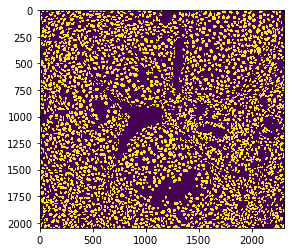

In [283]:
plt.imshow(m)

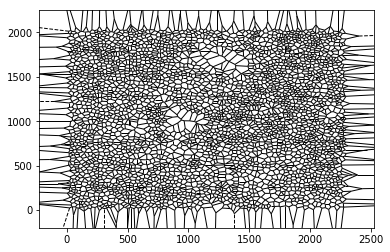

In [302]:
pts = [(c.cx, c.cy) for c in slide.cells]
vor = Voronoi(pts)

fig = voronoi_plot_2d(vor, show_vertices=False, show_points=False)
# plt.show()
plt.savefig('test.png', dpi=1000)

In [291]:
m = np.zeros((slide.height, slide.width)).astype(bool)
for cell in slide.cells:
    image = Image.fromarray(cell.cell_mask).filter(ImageFilter.FIND_EDGES)
#     print(image.toarray())
    m = np.ma.mask_or(m, np.array(image))

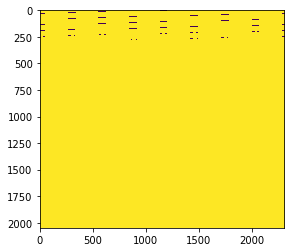

In [292]:
plt.imshow(m)

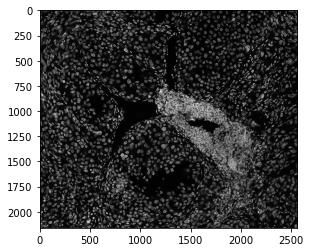

In [218]:
image = cv2.imread(input_image, cv2.IMREAD_COLOR)
plt.imshow(image)

In [156]:
len(slide.cells)

3617

In [161]:
pts = [(c.cx, c.cy) for c in slide.cells]
vor = Voronoi(pts[:100])

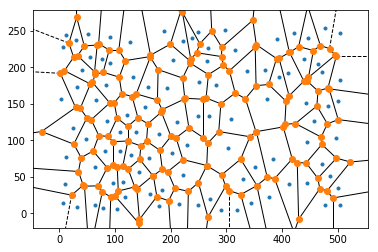

AttributeError: module 'matplotlib.pyplot' has no attribute 'rotate'

In [193]:
fig = voronoi_plot_2d(vor)
plt.show()

In [160]:
vor.vertices[:5]

array([[6.58970000e+03, 3.97000000e+02],
       [1.42979500e+05, 8.25000000e+01],
       [7.90925348e+03, 3.74859841e+02],
       [4.88185531e+03, 1.16146624e+03],
       [5.12531390e+02, 2.31467489e+03]])

In [166]:
len(vor.regions), vor.regions[:5]

(101,
 [[9, 6, 0, 1, 8],
  [-1, 0, 6, 7, 5],
  [27, 25, 24, 23, 26],
  [26, 22, 10, 23],
  [25, 7, 6, 9, 24]])

In [169]:
for r in vor.regions:
    if 9 in r:
        print(r)

[9, 6, 0, 1, 8]
[25, 7, 6, 9, 24]
[64, 10, 23, 24, 9, 8, 63]


In [165]:
len(vor.ridge_vertices), vor.ridge_vertices[:5]

(284, [[0, 1], [0, 6], [1, 8], [6, 9], [8, 9]])

In [170]:
len(vor.ridge_lines), vor.ridge_lines[:5]

AttributeError: 'Voronoi' object has no attribute 'ridge_lines'

In [172]:
len(vor.point_region), vor.point_region

(100, array([ 30,  88,  92,  96,  60,  74,  62,  37,  81,  75,  57,  11,  73,
         95,  97,  78,  10,  52, 100,  36,  54,  64,  98,  90,  65,  83,
         82,  27,  53,  80,  33,  89,  91,  79,  55,  26,  94,  50,  25,
         87,  56,  86,  99,  29,  58,  20,  93,  63,  12,  61,  38,  28,
         85,  84,  77,  13,  51,  46,  44,   0,   2,   8,   7,  15,  24,
         32,   9,  76,  17,   5,  48,  23,  71,  59,  69,   3,  21,   4,
         16,  67,  45,  19,  18,  66,  40,  22,  70,   6,  72,  68,  31,
         49,  35,  34,   1,  47,  42,  39,  41,  43]))

In [173]:
vor.regions[30]

[90, 52, 51, 15, 89]

In [177]:
for i in vor.regions[30]:
    print(vor.vertices[i])

[207.25632911  34.33860759]
[231.51425356  29.98462116]
[ 222.71428571 -269.21428571]
[ 221.52755906 -280.48818898]
[196.01329787  17.17819149]


In [203]:
polygon = []
for i in vor.regions[77]:
    xs = [int(x) for x in vor.vertices[i]]
    verti
    polygon.append((xs[0], xs[1]))
polygon

[(225, 157), (221, 185), (234, 205), (267, 189), (263, 157), (258, 156)]

In [204]:
# polygon = []

img = Image.new('L', (500, 300), 0)
ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
mask = np.array(img)

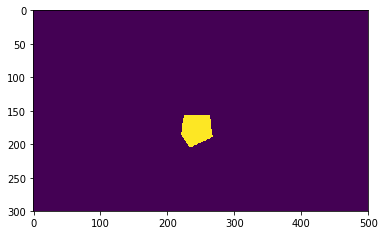

In [205]:
plt.imshow(mask)

In [261]:
def add_cytoplasm_masks(cells, width, height):
    pts = [(c.cx, c.cy) for c in cells]
    vor = Voronoi(pts)
    for i, region_i in enumerate(vor.point_region):
        if region_i != -1:
            cell = cells[i]
            region = vor.regions[region_i]
            vertices = [vor.vertices[x] for x in region]

            polygon = [(int(x), int(y)) for x, y in vertices]

            img = Image.new('L', (width, height), 0)
            ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
            mask = np.array(img).astype(bool)

            cell.cell_mask = mask
            cell.cell_polygon = polygon

In [262]:
add_cytoplasm_masks(slide.cells, slide.width, slide.height)

3617 3617


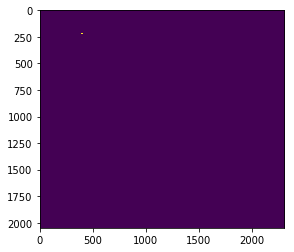

In [265]:
plt.imshow(slide.cells[100].nucleus_mask)

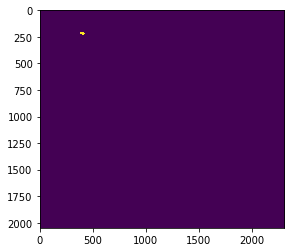

In [266]:
plt.imshow(slide.cells[100].cell_mask)

In [244]:
slide.cells[0].cell_polygon

In [249]:
slide.cells[0].cx

214

In [250]:
slide.cells[0].cy

13